# Lab 3 Faces

Jakub Darul

In [18]:
from numpy.random import RandomState
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition
import os
import math
import matplotlib.patches as mpatches
from PIL import Image
from typing import Dict

##  Preprocessing:
W zbiorze mam 50 osób, dla każdej od 15 do 50 zdjęć.
Używając openCv wykryłem, wyciąłem twarze, zamieniłem kolory zdjęć na skalę szarości i zmniejszyłem zdjęcia.
 (skrypt `extract_faces.py`)

In [19]:
home_dir = "/home/jacko"
faces_dir ="{}/Nextcloud/tmp_faces".format(home_dir)
shape=(128,128)

In [20]:
def get_person_img_array(person_dir:str)-> np.ndarray:
    photo_list= [Image.open(person_dir +"/"+ fn) for fn in os.listdir(person_dir)]
    return np.vstack([np.array(list(img.getdata())) for img in photo_list ])
    

In [21]:
def present_person(label:str,person_arr:np.ndarray,component_count=7):
    cols = 2
    rows =  math.ceil((component_count +1) /2)
    gs = gridspec.GridSpec(rows,cols)
    gs.update(hspace=0.4)
    
    fig = plt.figure()
    fig.set_size_inches(18, rows * 10)
    
    def grid(i:int):
        return gs[i// cols, i % cols]
    
    plot_i  =0
    
    domi_mean = person_arr.mean(axis=0)
    ax0 = fig.add_subplot(grid(plot_i))
    ax0.set_title("{} mean".format(label))
    ax0.imshow(domi_mean.reshape(shape),cmap='gray')
    
    pca = decomposition.PCA(n_components=component_count,whiten=True)
    pca.fit(person_arr)
    
    for evr,comp in zip(pca.explained_variance_ratio_,pca.components_):
        plot_i+=1
        ax = fig.add_subplot(grid(plot_i))
        ax.set_title("Principal component #{} \nExplained variance ratio: {}".format(plot_i,evr))
        ax.imshow(comp.reshape(64*2,64*2),cmap='gray')
        
    plt.show()

### Średnia i principal components wszystkich twarzy:

* Jak wygląda "średnia twarz" ?
* Jak wyglądają kolejne "principal components"?

Dla każdej osoby po kolei:

In [ ]:
person_dict = {person:get_person_img_array(faces_dir +"/"+ person) for person in os.listdir(faces_dir)}
for label,arr in person_dict.items():
    print("{} has {} photos:".format(label,arr.shape[0]))
    present_person(label,arr,component_count=3)

Dla wszystkich osób razem:

In [ ]:
arrays= [get_person_img_array(faces_dir +"/"+ person) for person in os.listdir(faces_dir)]
everybody = np.vstack(arrays)
present_person("Everybody",everybody)

### Noise reduction:
* Zauważmy też, że tylko niewielka część nowych wektorów bazowych ma istotny udział w tłumaczeniu pierwotnej wariancji zbioru (*explained variance ratio*).
* Jak wyglądają zrekonstruowane twarze, jeżeli obetniemy przestrzeń do 5, 15 i 50 najważniejszych?


In [7]:
def retransform(pca:decomposition.PCA,img:np.ndarray)-> np.ndarray:
    x= pca.transform(img.reshape(1,-1))
    return  pca.inverse_transform(x)

In [8]:
def pca_trained_on_everybody(components:int):
    pca = decomposition.PCA(n_components=components)
    pca.fit(everybody)
    return pca
pcas  = {comp:pca_trained_on_everybody(comp) for comp in [5,15,50]}
pics_to_reduce_noise = [arr[0] for arr in person_dict.values()]

In [ ]:
for pic in pics_to_reduce_noise:
    cols = 2
    rows =  math.ceil((len(pcas)+1) /2)
    gs = gridspec.GridSpec(rows,cols)
    gs.update(hspace=0.4)
    fig = plt.figure()
    fig.set_size_inches(18, rows * 10)
    def grid(i:int):
        return gs[i// cols, i % cols]
    plot_i  =0
    
    ax0 = fig.add_subplot(grid(plot_i))
    ax0.set_title("Original")
    ax0.imshow(pic.reshape(shape),cmap='gray')
    
    for comp,pca in pcas.items():
        plot_i+=1
        ax = fig.add_subplot(grid(plot_i))
        ax.set_title("{} components left ".format(comp))
        ax.imshow(retransform(pca,pic).reshape(shape),cmap='gray')
        
    plt.show()


Można dobrze zauważyć jak charakterystyczne elementy na niektórych zdjęciach (okulary) "odbijają się" na zdjęciach osób nie noszących okularów.

Dla pozostawionych 5,15 komponentów występują artefakty, dla 5 komponentów zdjęcia bywają bardzo rozmyte. Dla 50 principal components zdjęcia mają zadowalającą jakość porównywalnie do oryginału.

### Plot 2d

* Na koniec, ograniczmy przestrzeń do 2 najważniejszych wymiarów i zrzutujmy elementy zbioru na płaszczyznę 2D (kolorując punkty w zależności od klasy do której przynależą).
* Czy są łatwo separowalne?

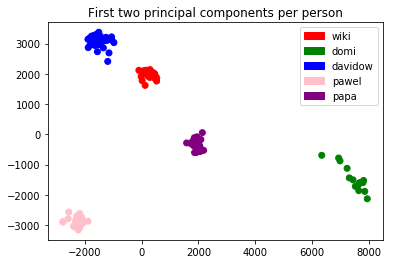

In [13]:
y = np.zeros((everybody.shape[0],),dtype=int)
X_orig = np.zeros(everybody.shape)

colors = ["red","green","blue","pink","purple","black"]
if (len(colors)< len(person_dict)):
    raise Exception("Think of more colors please")
    
offset=0
legend:Dict[int,str] = dict()
for i,tup in enumerate(person_dict.items()):
    label,arr = tup
    d_offset= arr.shape[0]
    X_orig[offset:offset+d_offset,:]= arr
    y[offset:offset+d_offset] = i
    offset = offset+ d_offset
    legend[i]=label
    
pca_2d = decomposition.PCA(n_components=2)
pca_2d.fit(X_orig)
X = pca_2d.transform(X_orig)

handles = [mpatches.Patch(color=colors[color_int] , label=label) for color_int, label in legend.items()]

plt.title("First two principal components per person")
plt.legend(handles= handles)
y_color = [colors[c] for c in y]
plt.scatter(X[:,0],X[:,1],c=y_color)
plt.show()

Osoby są wyraźnie oddzielone, jedyna dziewczyna w datasecie jest bardzo oddzielona od reszty osób, osoby z okularami (czerwony, niebieski) są niedaleko siebie